# Семинар 3

# Токенизация по подсловам

Для большинства задач нет необходимости в обучении своих токенизаторов и уж тем более единицам в работе потребуется писать реализацию токенизаторов с нуля, однако понимание мелких отличий и их приницпов работы необходимо для искуссного манипулирования их слабыми и сильными сторонам при работе с разными предобученными моделями.

Замечательная библиотека tokenizers от команды huggingface содержит в себе все самое необходимое для базовой работы с токенизаторами и настройке их под свои нужды. Прикреплю ссылку на их [документацию](https://github.com/huggingface/tokenizers) для самостоятельного знакомства с данной библиотекой.

Далее мы реализуем 3 базовые модели токенизации по подсловам и познакомимся что такое пре-токенизация

Пайплайн токенизации в общем случае выглядит следующим образом:

![](./data/images/tokenization_pipeline.svg)

Прежде чем разбить текст на подслова (в соответствии с его моделью), токенизатор выполняет два шага: нормализацию и предварительную токенизацию(пре-токенизацию).

Пре-токенизация представляет собой этап предварительной обработки текста, включающий разделение текста на токены до его фактической токенизации. Этот процесс может включать в себя удаление специальных символов, приведение текста к нижнему регистру и т. д. Пре-токенизация помогает подготовить текст для более эффективной последующей обработки, такой как токенизация и векторизация.

Этап нормализации включает в себя некоторую общую очистку, такую как удаление ненужных пробелов, нижнего регистра(если это обусловлено задачей) и/или удаление акцентов/ударений. Если вы знакомы с нормализацией Unicode (например, NFC или NFKC), это также может быть включено в этап нормализации текста.

Токенизатор из библиотеки Transformers имеет атрибут backend_tokenizer, который предоставляет доступ к базовому токенизатору из библиотеки Tokenizers,  про которую мы говорили ранее:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer.backend_tokenizer))

<class 'tokenizers.Tokenizer'>


Например, атрибут normalizer объекта tokenizer имеет метод normalize_str(), который мы можем использовать, чтобы увидеть, как выполняется нормализация:

In [ ]:
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


Как мы увидим далее, токенизатор нельзя обучить только на необработанном тексте. Вместо этого нам сначала нужно разбить тексты на небольшие объекты, такие как слова. Вот где начинается этап пре-токенизации. Токенизатор на основе слов может разделять необработанный текст на слова с использованием пробелов и знаков препинания. Эти слова будут границами сабтокенов для токенов по подсловам, которые токенизатор может выучить во время своего обучения.

In [ ]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

In [ ]:
tokenizer.decode(tokenizer.encode(" Hello, how are  you?"), skip_special_tokens=True), \
tokenizer.decode(tokenizer.encode("Hello, how are  you?"), skip_special_tokens=True)

('hello, how are you?', 'hello, how are you?')

Обратите внимание, что токенизатор отслеживает смещения сабтокенов по тексту. Здесь токенизатор игнорирует два пробела и заменяет их только одним, но смещение между are и you учитывает его.

Поскольку мы используем токенизатор BERT, предварительная токенизация включает разделение на пробелы и знаки препинания. У других токенизаторов могут быть другие правила для этого шага.

Например, токенизатор GPT-2 также разделяет текст на пробелы и знаки препинания, но сохранит пробелы и заменит их символом Ġ, что позволит восстановить исходные пробелы, если мы расшифруем токены:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('Ġ', (14, 15)),
 ('Ġyou', (15, 19)),
 ('?', (19, 20))]

In [ ]:
tokenizer.decode(tokenizer.encode(" Hello, how are  you?"), skip_special_tokens=True), \
tokenizer.decode(tokenizer.encode("Hello, how are  you?"), skip_special_tokens=True)

(' Hello, how are  you?', 'Hello, how are  you?')

Также обратите внимание, что в отличие от токенизатора BERT, этот токенизатор не игнорирует двойной пробел.

В качестве последнего примера давайте взглянем на токенизатор T5, который основан на алгоритме SentencePiece:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

In [ ]:
tokenizer.decode(tokenizer.encode(" Hello, how are  you?"), skip_special_tokens=True)

'Hello, how are you?'

In [ ]:
tokenizer.decode(tokenizer.encode("Hello, how are  you?"), skip_special_tokens=True)

'Hello, how are you?'

Как и токенизатор GPT2, он сохраняет пробелы и заменяет их определенным токеном `▁`, но токенизатор T5 разбивает только на пробелы, а не на знаки препинания. Также обратите внимание, что он по умолчанию добавил пробел в начале предложения (перед Hello) и проигнорировал двойной пробел между are и you.

Теперь, когда мы немного ознакомились с тем, как различные токенизаторы обрабатывают текст, мы можем расссмотреть самые базовые алгоритмы. Мы начнем с краткого рассмотрения широко применимого алгоритма SentencePiece, а затем рассмотрим, как работают три основных алгоритма, используемые для токенизации на подслова.

---------------------------------------------------

### Алгоритм SentencePiece

## Обучим модель с нуля

Для примера работы возмем текстовые данные из книг о Гарри Поттере, и на этом относительно небольшом наборе данных попробуем обучить с нуля наши вручную написанные токенизаторы по подсловам

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict, Counter

data_path = './data/Garri_Potter_1-7_chasti-world65.spcs.bio/'

corpus = list()

for f_path in Path(data_path).iterdir():
    with open(f_path.absolute(), 'r', encoding='utf-8') as fp:
        data = fp.read()
    corpus.append(data)
sum(len(data) for data in corpus)

6213401

## Напишем свою реализацию токенизаторов

###  BPE

Алгоритм BPE (Byte Pair Encoding) - это алгоритм сжатия словаря, который используется для токенизации текста. Он был предложен в 1994 году и широко применяется в области обработки естественного языка (NLP) для различных задач, таких как машинный перевод и распознавание речи.

BPE работает путем последовательного объединения наиболее часто встречающихся пар символов в тексте. Эти пары символов затем заменяются новым символом, который ранее не встречался в тексте. Процесс объединения повторяется до достижения заданного размера словаря или до того момента, когда все символы в тексте станут одиночными токенами.



-----------------------------------------------

Для начала давайте реализуем алгоритм BPE. Конечно это будет не оптимизированная его версия, мы просто попробуем проделать обучение токенизатора руками, чтобы лучше понять алгоритм.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

Сначала нужно предварительно преобразовать этот корпус в слова. Поскольку мы реплицируем токенизатор BPE (как в в GPT2), мы будем использовать токенизатор gpt2 для пре-токенизации и вычислим частоту каждого слова в корпусе, после пре-токенизации

In [ ]:
word_freqs = defaultdict(int)

word_freqs = None

for text in tqdm(corpus):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    if word_freqs is None:
        word_freqs = Counter(new_words)
    else:
        word_freqs.update(Counter(new_words))

len(word_freqs)

  0%|          | 0/7 [00:00<?, ?it/s]

85077

In [ ]:
for key, value in word_freqs.most_common(10):
    print(f"'{tokenizer.decoder.decode([key])}'\t", value)

','	 117415
'.'	 61648
' '	 42543
' —'	 35208
'
'	 34337
' и'	 25527
'—'	 24242
' в'	 19845
' Гарри'	 18171
' не'	 17593


делим на минимальные составные элементы, которые потом будем объединять

Сформируем базовый словарь из всех символов, используемых в корпусе:

1. В цикле for word in word_freqs.keys(): проходит по каждому слову в ключах словаря word_freqs.

2. Во вложенном цикле for letter in word: проходит по каждой букве в текущем слове.

3. Внутри вложенного цикла проверяется, если буква letter еще не находится в списке alphabet, то она добавляется в список с помощью метода append(letter).

4. После завершения циклов, список alphabet сортируется в алфавитном порядке с помощью метода sort().

5. Затем, с помощью функции print(), выводится длина списка alphabet и сам список на экран.



In [ ]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(len(alphabet))
print(alphabet)

145
['!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'Â', 'Ð', 'Ñ', 'â', 'Ċ', 'Ġ', 'Ģ', 'ģ', 'Ĥ', 'ĥ', 'Ħ', 'ħ', 'Ĩ', 'ĩ', 'Ī', 'ī', 'Ĭ', 'ĭ', 'Į', 'į', 'İ', 'ı', 'Ĳ', 'ĳ', 'Ĵ', 'ĵ', 'Ķ', 'ķ', 'ĸ', 'Ĺ', 'ĺ', 'Ļ', 'ļ', 'Ľ', 'ľ', 'Ŀ', 'ŀ', 'Ł', 'ł', 'Ń']


Добавляем спецсимволы, которые нам нужны для тренировки

In [ ]:
vocab = ["<|endoftext|>"] + alphabet.copy()

Теперь нам нужно разбить каждое слово на отдельные символы, чтобы начать обучение:

In [ ]:
splits = {word: [c for c in word] for word in word_freqs.keys()}

Напишем функцию, которая вычисляет частоту каждой пары. Нам нужно будет использовать это на каждом этапе обучения

In [ ]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

Давайте взглянем на часть этого словаря после первоначального разбиения:

In [ ]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('\n', '\n'): 235
('Э', 'т'): 285
('т', 'а'): 5063
('к', 'н'): 729
('н', 'и'): 7200
('и', 'г'): 449


Найдем наиболее часто встречающейся пары

In [ ]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('т', 'о') 12104


In [ ]:
merges = {('т', 'о'): "то"}
vocab.append("то")

применим это слияние к нашему словарю

In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [ ]:
splits = merge_pair('т', 'о', splits)
print(splits["Это"])

['Э', 'то']


Теперь у нас есть все необходимое для обучения, пока мы не выучим все нужные нам слияния. Чтобы не тратить много времени словарь размером 150 подслов

In [ ]:
vocab_size = 150

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

In [ ]:
print(merges)

{('т', 'о'): 'то', ('н', 'а'): 'на', ('а', 'л'): 'ал', ('п', 'о'): 'по', ('н', 'е'): 'не', ('н', 'о'): 'но', ('е', 'р'): 'ер', ('р', 'и'): 'ри', ('с', 'т'): 'ст', ('н', 'и'): 'ни', ('к', 'о'): 'ко', ('р', 'о'): 'ро', ('г', 'о'): 'го', ('р', 'а'): 'ра', ('к', 'а'): 'ка', ('л', 'и'): 'ли', ('л', 'а'): 'ла', ('в', 'о'): 'во', ('т', 'ь'): 'ть', ('л', 'о'): 'ло', ('с', 'я'): 'ся', ('з', 'а'): 'за', ('.', '\n'): '.\n', ('д', 'е'): 'де', ('в', 'а'): 'ва', ('а', 'р'): 'ар', ('м', 'и'): 'ми'}


Чтобы токенизировать новый текст, мы предварительно его токенизируем, разделяем, а затем применяем все изученные правила слияния

In [ ]:
def tokenize(text):
    pre_tokenized_text = text.split(" ")
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

In [ ]:
print(tokenize("Это была оченб интересная книга, спасибо!"))

['Э', 'то', 'б', 'ы', 'ла', 'о', 'ч', 'е', 'н', 'б', 'и', 'н', 'т', 'ер', 'е', 'с', 'на', 'я', 'к', 'ни', 'г', 'а', ',', 'с', 'п', 'а', 'с', 'и', 'б', 'о', '!']


### Wordpiece

Word Piece - это алгоритм токенизации, разработанный Google для обучения модели BERT. С тех пор он был повторно использован во многих энкодерных трансформерных моделях. Он очень похоже на BPE с точки зрения обучения, но фактическая токенизация выполняется по-другому.

Основным преимуществом Wordpiece является то, что он может обрабатывать неизвестные слова, разбивая их на более мелкие подслова, которые уже могут быть в словаре. Это позволяет моделям лучше работать с неизвестными словами и улучшает качество обработки текста. Однако, недостатком Wordpiece является то, что он может создавать слишком много токенов, что может привести к увеличению размера словаря и ухудшению производительности модели.

Как и в случае с BPE, это просто педагогический подход, не стоит использовать на большом корпусе данных.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Как и до этого для начала на слова и посчитаем их частотность

In [ ]:
word_freqs = defaultdict(int)
for text in tqdm(corpus):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

len(word_freqs)

  0%|          | 0/7 [00:00<?, ?it/s]

81572

Алфавит представляет собой уникальный набор, состоящий из всех первых букв слов и всех остальных букв, которые появляются в словах с префиксом ##

In [ ]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

print(len(alphabet))
print(alphabet)

253
['!', '"', '##0', '##1', '##2', '##3', '##4', '##5', '##6', '##7', '##8', '##9', '##C', '##E', '##F', '##G', '##H', '##I', '##L', '##M', '##P', '##R', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', '##\xad', '##Ё', '##А', '##Б', '##В', '##Г', '##Д', '##Е', '##Ж', '##З', '##И', '##Й', '##К', '##Л', '##М', '##Н', '##О', '##П', '##Р', '##С', '##Т', '##У', '##Ф', '##Х', '##Ц', '##Ч', '##Ш', '##Щ', '##Ъ', '##Ы', '##Ь', '##Э', '##Ю', '##Я', '##а', '##б', '##в', '##г', '##д', '##е', '##ж', '##з', '##и', '##й', '##к', '##л', '##м', '##н', '##о', '##п', '##р', '##с', '##т', '##у', '##ф', '##х', '##ц', '##ч', '##ш', '##щ', '##ъ', '##ы', '##ь', '##э', '##ю', '##я', '##ё', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'

Также добавляем специальные токены, используемые моделью, в начало этого словаря. В случае BERT это список  
`["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]`

- [PAD]: Используется для дополнения последовательностей до одинаковой длины.
- [UNK]: Представляет неизвестные слова или токены.
- [CLS]: Используется для обозначения начала последовательности и для классификации предложений.
- [SEP]: Разделяет два предложения во входной последовательности.
- [MASK]: Используется во время обучения для маскирования токенов в задаче предсказания.


In [ ]:
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

Далее нам нужно разделить каждое слово на все буквы, которые не являются первыми, с префиксом ##:

In [ ]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

Давайте напишем функцию, которая вычисляет оценку каждой пары. Нам нужно будет использовать это на каждом этапе обучения

In [ ]:
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [ ]:
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('Д', '##ж'): 4.157047649739005e-06
('##ж', '##о'): 5.125240054961902e-08
('##о', '##а'): 2.799197577959159e-10
('##а', '##н'): 1.9473651717776583e-07
('##н', '##н'): 2.731086613084283e-07
('Р', '##о'): 1.6281092444834705e-06


In [ ]:
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('##H', '##L') 0.5


In [ ]:
vocab.append("HL")

In [ ]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [ ]:
[item for item in splits.keys() if "HL" in item]

['PHLEGM']

In [ ]:
splits = merge_pair('##H', '##L', splits)
splits["PHLEGM"]

['P', '##HL', '##E', '##G', '##M']

Теперь у нас есть все необходимое для обучения, пока мы не выучим все нужные нам слияния. Чтобы не тратить много времени ограничим словарь размером 320 подслов

In [ ]:
vocab_size = 320
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [ ]:
print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '!', '"', '##0', '##1', '##2', '##3', '##4', '##5', '##6', '##7', '##8', '##9', '##C', '##E', '##F', '##G', '##H', '##I', '##L', '##M', '##P', '##R', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##q', '##r', '##s', '##t', '##u', '##v', '##w', '##x', '##y', '##z', '##\xad', '##Ё', '##А', '##Б', '##В', '##Г', '##Д', '##Е', '##Ж', '##З', '##И', '##Й', '##К', '##Л', '##М', '##Н', '##О', '##П', '##Р', '##С', '##Т', '##У', '##Ф', '##Х', '##Ц', '##Ч', '##Ш', '##Щ', '##Ъ', '##Ы', '##Ь', '##Э', '##Ю', '##Я', '##а', '##б', '##в', '##г', '##д', '##е', '##ж', '##з', '##и', '##й', '##к', '##л', '##м', '##н', '##о', '##п', '##р', '##с', '##т', '##у', '##ф', '##х', '##ц', '##ч', '##ш', '##щ', '##ъ', '##ы', '##ь', '##э', '##ю', '##я', '##ё', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', '

Чтобы токенизировать новый текст, сначала применяется пре-токенизация, разделяем, а затем применяем алгоритм токенизации к каждому слову. То есть мы ищем самое большое подслово, начиная с начала первого слова, и разделяем его, затем повторяем процесс со второй частью и так далее для остальной части этого слова и следующих слов в тексте

In [ ]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [ ]:
print(encode_word("Avada"))
print(encode_word("Avada "))

['Avada']
['[UNK]']


In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word) for word in pre_tokenized_text]
    return sum(encoded_words, [])

In [ ]:
print(tokenize("Заклинание Avada Kedavra полетело прямо в Гарри"))

['Avada', 'K', '##e', '##d', '##a', '##v', '##r', '##a', 'i', '##s', 'a', 'd', '##e', '##a', '##d', '##l', '##y', 's', '##p', '##e', '##l', '##l']


### Unigram

Теперь давайте реализуем модель Unigram. Как и в случае с BPE и WordPiece, это не эффективная реализация алгоритма Unigram (как раз наоборот), но она должна помочь вам понять его немного лучше.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

Как и в случае с BPE и WordPiece, мы начинаем с подсчета количества вхождений каждого слова в корпус

In [ ]:
word_freqs = defaultdict(int)
for text in tqdm(corpus):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(len(word_freqs))

  0%|          | 0/7 [00:00<?, ?it/s]

132117


Затем нам нужно инициализировать наш словарь чем-то большим, чем размер словаря, который нам нужен в конце. Нам необходимо включить все основные символы (иначе мы не сможем токенизировать каждое слово), но для более крупных подстрок мы оставим только самые распространенные, поэтому сортируем их по частоте

In [ ]:
char_freqs = defaultdict(int)
subwords_freqs = defaultdict(int)
for word, freq in word_freqs.items():
    for i in range(len(word)):
        char_freqs[word[i]] += freq
        # Loop through the subwords of length at least 2
        for j in range(i + 2, len(word) + 1):
            subwords_freqs[word[i:j]] += freq

# Sort subwords by frequency
sorted_subwords = sorted(subwords_freqs.items(), key=lambda x: x[1], reverse=True)
print(len(sorted_subwords))
sorted_subwords[:10]

1230993


[('▁п', 87443),
 ('▁с', 79744),
 ('▁н', 75473),
 ('▁в', 72882),
 ('то', 68886),
 ('▁—', 59413),
 ('на', 57051),
 ('▁о', 55384),
 ('ал', 52963),
 ('ст', 51724)]

Мы группируем символы с самыми частыми подсловами, чтобы получить начальный словарь размером в 300 подслов

In [ ]:
token_freqs = list(char_freqs.items()) + sorted_subwords[: 300 - len(char_freqs)]
token_freqs = {token: freq for token, freq in token_freqs}

Вычислим сумму всех частот, чтобы преобразовать частоты в вероятности. Для нашей модели мы будем хранить логарифмы вероятностей, потому что складывать логарифмы вычислительно стабильнее, чем умножать небольшие числа, и это упростит вычисление loss`а

In [ ]:
from math import log

total_sum = sum([freq for token, freq in token_freqs.items()])
model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

Основная функция, которая токенизирует слова использует алгоритм Витерби. Этот алгоритм вычисляет наилучшую сегментацию каждой подстроки слова, которую мы сохраним в переменной с именем `best_segmentations`. Мы будем хранить по одному словарю на каждую позицию в слове (от 0 до его общей длины) с двумя ключами: индексом начала последнего токена в лучшей сегментации и оценкой лучшей сегментации. Используя индекс начала последнего токена, мы сможем получить полную сегментацию после полного заполнения списка.

Заполнение списка выполняется всего за два цикла: основной цикл проходит по каждой начальной позиции, а второй цикл проверяет все подстроки, начинающиеся с этой начальной позиции. Если подстрока есть в словаре, у нас есть новая сегментация слова до этой конечной позиции, которую мы сравниваем с тем, что находится в `best_segmentations`.

После завершения основного цикла мы просто начинаем с конца и переходим от одной начальной позиции к другой, записывая токены по ходу, пока не достигнем начала слова

In [ ]:
def encode_word(word, model):
    best_segmentations = [{"start": 0, "score": 1}] + [
        {"start": None, "score": None} for _ in range(len(word))
    ]
    for start_idx in range(len(word)):

        best_score_at_start = best_segmentations[start_idx]["score"]
        for end_idx in range(start_idx + 1, len(word) + 1):
            token = word[start_idx:end_idx]
            if token in model and best_score_at_start is not None:
                score = model[token] + best_score_at_start
                # If we have found a better segmentation ending at end_idx, we update
                if (
                    best_segmentations[end_idx]["score"] is None
                    or best_segmentations[end_idx]["score"] > score
                ):
                    best_segmentations[end_idx] = {"start": start_idx, "score": score}

    segmentation = best_segmentations[-1]
    if segmentation["score"] is None:
        # We did not find a tokenization of the word -> unknown
        return ["<unk>"], None

    score = segmentation["score"]
    start = segmentation["start"]
    end = len(word)
    tokens = []
    while start != 0:
        tokens.insert(0, word[start:end])
        next_start = best_segmentations[start]["start"]
        end = start
        start = next_start
    tokens.insert(0, word[start:end])
    return tokens, score

In [ ]:
print(encode_word("Avada", model))
print(encode_word("Kedavra", model))

(['A', 'v', 'a', 'd', 'a'], 64.41190166409532)
(['K', 'e', 'd', 'a', 'v', 'r', 'a'], 87.83976244918364)


In [ ]:
def compute_loss(model):
    loss = 0
    for word, freq in word_freqs.items():
        _, word_loss = encode_word(word, model)
        loss += freq * word_loss
    return loss

In [ ]:
compute_loss(model)

20490954.87309149

Вычислить скор для каждого токена также не очень сложно; нам просто нужно вычислить потери для моделей, полученных путем удаления каждого токена

In [ ]:
import copy


def compute_scores(model):
    scores = {}
    model_loss = compute_loss(model)
    for token, score in tqdm(model.items()):
        # We always keep tokens of length 1
        if len(token) == 1:
            continue
        model_without_token = copy.deepcopy(model)
        _ = model_without_token.pop(token)
        scores[token] = compute_loss(model_without_token) - model_loss
    return scores

In [ ]:
scores = compute_scores(model)
len(scores)
# print(scores["ll"])
# print(scores["his"])

  0%|          | 0/300 [00:00<?, ?it/s]

146

Последнее, что нам нужно сделать, это добавить в словарь специальные токены, используемые моделью, а затем выполнять цикл до тех пор, пока мы не сократим словарь на такое количество токенов, чтобы достичь желаемого размера словаря

In [ ]:
percent_to_remove = 0.1
while len(model) > 100:
    scores = compute_scores(model)
    sorted_scores = sorted(scores.items(), key=lambda x: x[1])
    # Remove percent_to_remove tokens with the lowest scores.
    for i in range(int(len(model) * percent_to_remove)):
        _ = token_freqs.pop(sorted_scores[i][0])

    total_sum = sum([freq for token, freq in token_freqs.items()])
    model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

IndexError: list index out of range

Чтобы токенизировать текст, нам просто нужно применить пре-токенизацию, а затем использовать нашу функцию `encode_word`

In [ ]:
def tokenize(text, model):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in words_with_offsets]
    encoded_words = [encode_word(word, model)[0] for word in pre_tokenized_text]
    return sum(encoded_words, [])


tokenize("Заклинание Avada Kedavra полетело прямо в Гарри", model)

['▁',
 'З',
 'а',
 'к',
 'л',
 'и',
 'н',
 'а',
 'н',
 'и',
 'е',
 '▁',
 'A',
 'v',
 'a',
 'd',
 'a',
 '▁',
 'K',
 'e',
 'd',
 'a',
 'v',
 'r',
 'a',
 '▁по',
 'л',
 'е',
 'т',
 'е',
 'л',
 'о',
 '▁',
 'п',
 'р',
 'я',
 'м',
 'о',
 '▁в',
 '▁Гарри']

# Семплирование текста

На сегодняшнем занятии мы рассмотрим основные наиболее часто используемые методы семплирования, и особенности их использования

Самыми часто используемыми методами являются:
- Greedy-search
- Beam-search
- Top-k sampling
- Nucleus sampling (Top-p)

Стратегии декодирования, такие как beam_search, играющие ключевую роль в генерации текста, часто остаются без внимания. В этой статье мы исследуем, как LLM генерируют текст, погружаясь в механику жадной генерации (Greedy search) и beam-search, а также техник семплирования с использованием top-k и nucleus-sampling.

Давайте начнем с простого примера, и попробуем сгенерировать 5 токенов старенькой, но проверенной моделью GPT-2

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

n_tokens_to_generate = 5

# Здесь модель GPT-2 генерирует текст на основе входных идентификаторов (input_ids).
# Метод generate создает выходные данные, представляющие сгенерированный текст.
outputs = model.generate(input_ids, max_length=len(input_ids.squeeze()) + n_tokens_to_generate)

# Затем эти выходные данные декодируются обратно в текст с помощью токенизатора.
# Параметр skip_special_tokens=True указывает на то, что специальные токены
 # (например, токены начала и конца текста) должны быть пропущены при декодировании.
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Generated text: {generated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text: I have a dream of being a doctor.


Предложение "I have a dream of being a doctor." кажется сгенерированным GPT-2. Однако GPT-2 не сгенерировал это предложение буквально.

Существует распространенное заблуждение, что LLM, такие как GPT-2, напрямую производят текст. На самом деле это не так. Вместо этого LLM вычисляют логиты, которые являются оценками, присваиваемыми каждому возможному токену в их словаре. Упрощенно можно так проиллюстративать процесс генерации одного токена:

![](./data/images/sampling_1.png)

Токенизатор, в данном случае Byte-Pair Encoding, переводит каждый токен входного текста в соответствующий идентификатор токена. Затем GPT-2 использует эти идентификаторы токенов в качестве входных данных и пытается предсказать следующий наиболее вероятный токен. Наконец, модель генерирует логиты, которые преобразуются в вероятности с использованием функции softmax.

Например, модель присваивает вероятность 17% тому, что токен для "of" будет следующим после "I have a dream". Этот вывод фактически представляет собой ранжированный список потенциальных следующих токенов в последовательности. Более формально, мы обозначаем эту вероятность как
P(of | I have a dream) = 0.17

Авторегрессивные модели, такие как GPT, предсказывают следующий токен в последовательности на основе предшествующих токенов. Рассмотрим последовательность токенов w = (w_1, w_2, ..., w_t). Совместная вероятность этой последовательности P(w) может быть разложена как:

![](./data/images/sampling_2.png)

Каждый токен \( w_i \) в последовательности, $P(w_i | w_1, \ldots, w_{i-1})$ представляет условную вероятность \( w_i \), учитывая все предшествующие токены $ (w_1, \ldots, w_{i-1}) $. GPT-2 вычисляет эту условную вероятность для каждого из 50,257 токенов в своем словаре.

Этот вычислительный процесс приводит к важному вопросу в обработке естественного языка:

> **Как мы используем эти вероятности для генерации текста?**

Здесь на сцену выходят стратегии декодирования, такие как **Greedy-search** и **Beam-search**.

## Greedy-search

Greedy-search - это метод декодирования, который на каждом шаге выбирает наиболее вероятный токен в качестве следующего токена в последовательности. Проще говоря, он сохраняет только наиболее вероятный токен на каждом этапе, отбрасывая все другие потенциальные варианты. Используя наш пример:

Шаг 1: Вход: "I have a dream" → Наиболее вероятный токен: "of"  
Шаг 2: Вход: "I have a dream of" → Наиболее вероятный токен: "being"  
Шаг 3: Вход: "I have a dream of being" → Наиболее вероятный токен: "a"  
Шаг 4: Вход: "I have a dream of being a" → Наиболее вероятный токен: "doctor"  
Шаг 5: Вход: "I have a dream of being a doctor" → Наиболее вероятный токен: "."

Хотя этот подход может показаться интуитивным, важно отметить, что жадный поиск недальновиден: он учитывает только наиболее вероятный токен на каждом шаге, не рассматривая общее влияние на последовательность. Это свойство делает его быстрым и эффективным, так как ему не нужно отслеживать несколько последовательностей, но это также означает, что он может упустить лучшие последовательности, которые могли бы появиться с немного менее вероятными следующими токенами.

Далее давайте проиллюстрируем реализацию жадного поиска. Мы выбираем токен с наивысшим логитом, вычисляем его логарифмическую вероятность и добавляем его в дерево (добавление только для отображения). Мы повторим этот процесс для пяти токенов.

In [ ]:
# if troubles with installation on linux

# !sudo apt-get install graphviz libgraphviz-dev pkg-config

In [ ]:
import matplotlib.pyplot as plt

import networkx as nx
import numpy as np
import time

In [ ]:
def get_log_prob(logits, token_id):
    # Compute the softmax of the logits
    # YOUR_CODE_HERE

    # Get the log probability of the token
    # YOUR_CODE_HERE
    return token_log_probability

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = None  # YOUR_CODE_HERE
    token_id = None  # YOUR_CODE_HERE

    # Compute the score of the predicted token
    token_score = None  # YOUR_CODE_HERE

    # Add the predicted token to the list of input ids
    new_input_ids = None  # YOUR_CODE_HERE

    # decode new token
    next_token = None  # YOUR_CODE_HERE

    # Add node and edge to graph
    current_node = list(graph.successors(node))[0]

    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100

    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

In [ ]:
# solved


def get_log_prob(logits, token_id):
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability


def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    # Compute the score of the predicted token
    token_score = get_log_prob(logits, token_id)

    # Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Add node and edge to graph

    next_token = tokenizer.decode(token_id, skip_special_tokens=True)

    current_node = list(graph.successors(node))[0]

    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100

    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

In [ ]:
# Parameters
length = 5
beams = 1

# Create a balanced tree with height 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: I have a dream of being a doctor.


Наш жадный поиск генерирует тот же текст, что и библиотека transformers: "I have a dream of being a doctor.". Давайте визуализируем созданное нами дерево.

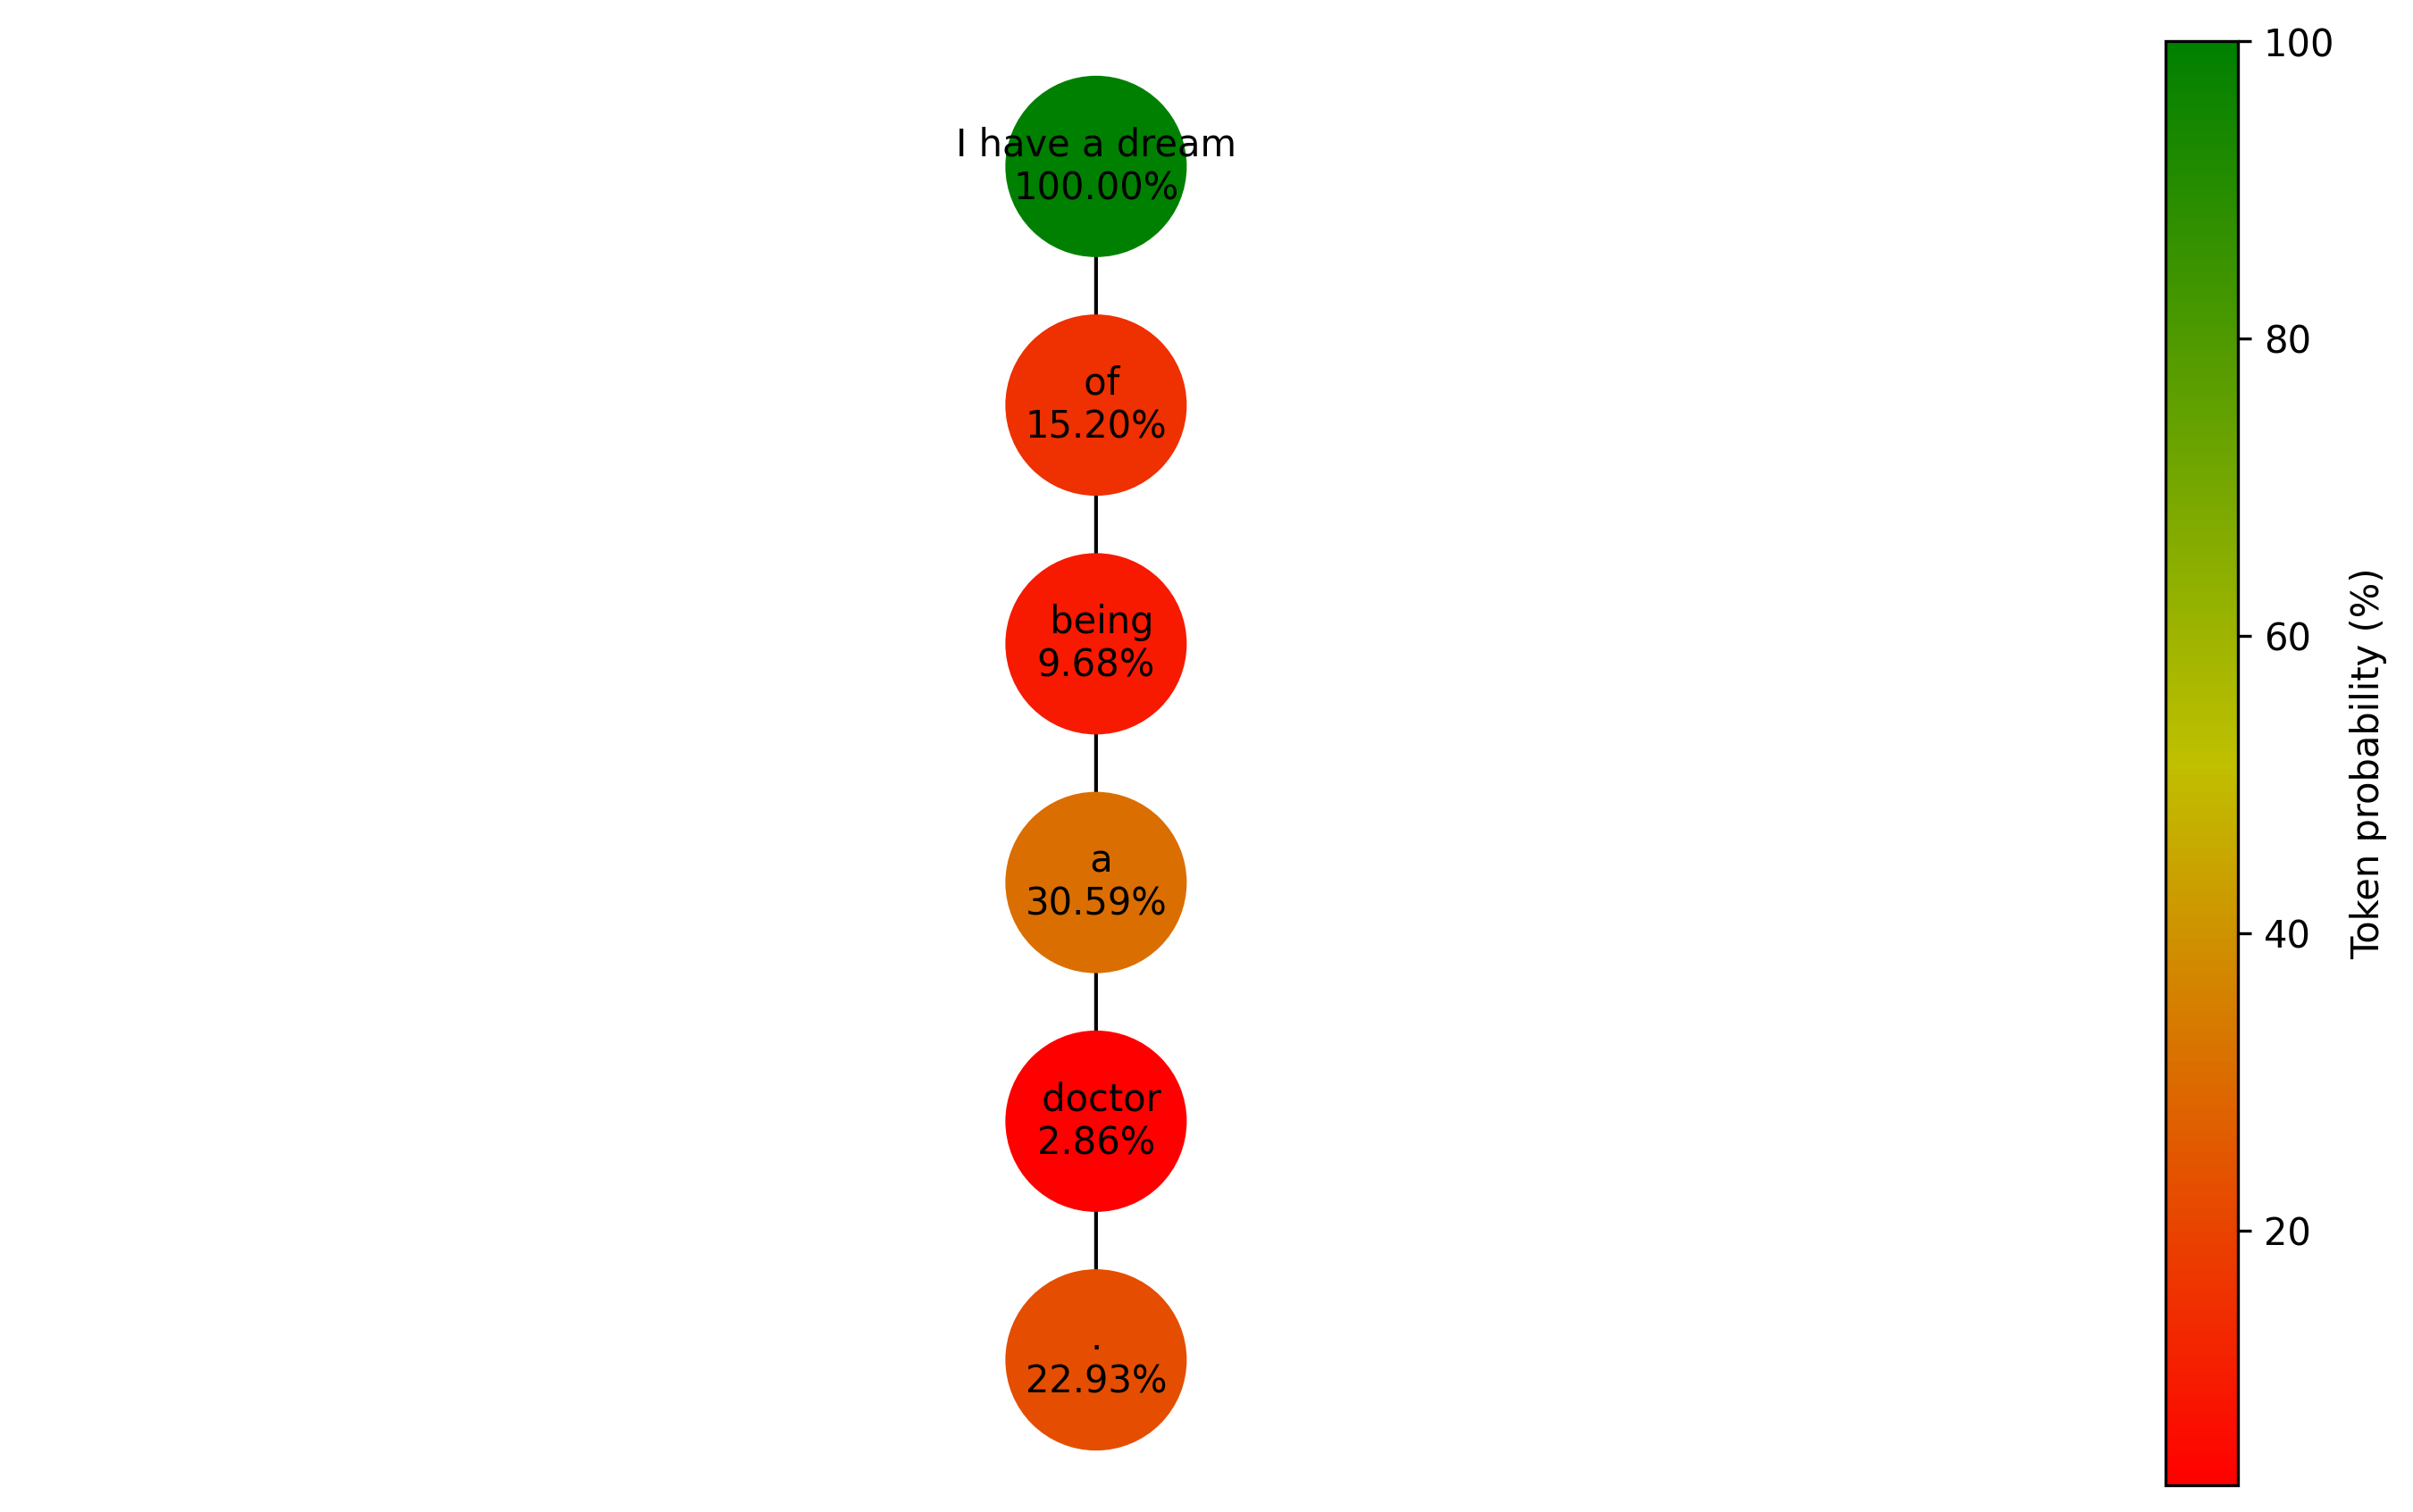

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4,
                          node_color=scores, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Plot graph
plot_graph(graph, length, 1.5, 'token')

В этом графе верхний узел хранит входной токены (с вероятностью 100%), в то время как все остальные узлы представляют сгенерированные токены. Хотя каждый токен в этой последовательности был наиболее вероятным на момент предсказания, "being" и "doctor" были назначены относительно низкие вероятности 9.68% и 2.86% соответственно. Это предполагает, что "of", наш первый предсказанный токен, может быть не самым подходящим выбором, так как он привел к "being", который является довольно маловероятным.

В следующем разделе мы исследуем, как beam-search может решить эту проблему.

## Beam-search

В отличие от жадного поиска, который учитывает только следующий наиболее вероятный токен, поиск луча принимает во внимание $n$ наиболее вероятных токенов, где $n$ представляет количество beam`ов. Эта процедура повторяется до достижения предопределенной максимальной длины или появления токена конца последовательности. В этот момент последовательность (или "beam") с самым высоким общим баллом выбирается в качестве вывода.

Мы можем адаптировать предыдущую функцию, чтобы учитывать $n$ наиболее вероятных токенов, а не только один. Здесь мы будем поддерживать оценку последовательности $logP(w)$, которая является кумулятивной суммой логарифма вероятности каждого токена в beam`е. Мы нормализуем этот балл по длине последовательности, чтобы предотвратить предвзятость в пользу более длинных последовательностей (этот фактор можно регулировать). И снова, мы сгенерируем пять дополнительных токенов, чтобы завершить предложение "I have a dream".

In [ ]:
from tqdm.notebook import tqdm

# Данный код определяет функцию greedy_sampling(logits, beams), которая используется для выбора токенов
# с наибольшей вероятностью из логитов (логарифмов вероятностей) на основе жадного алгоритма.
# Функция принимает два аргумента: logits - логиты, представляющие вероятности каждого токена, и
# eams - количество токенов, которые нужно выбрать. Функция использует метод topk библиотеки
# PyTorch для выбора beams токенов с наибольшей вероятностью из logits. Затем функция возвращает
# индексы выбранных токенов.
def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices

def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.8, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Compute the score of the predicted token
        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        # Recursive call
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

# Parameters
length = 5
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)

  0%|          | 0/63 [00:00<?, ?it/s]

---------------------------------------------------

Функция вычисляет оценки для 63 токенов и beams^length = 5² = 25 возможных последовательностей. В нашей реализации вся информация хранится в графе. Наш следующий шаг - извлечь лучшую последовательность.

Сначала мы определяем листовой узел с самой высокой оценкой последовательности. Затем мы находим кратчайший путь от корня до этого листа. Каждый узел на этом пути содержит токен из оптимальной последовательности. Вот как мы можем это реализовать:

In [ ]:
def get_best_sequence(G):
    # Create a list of leaf nodes
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    # Get the leaf node with the highest cumscore
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])

    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


Лучшей(наиболее вероятной) последовательностью, похоже, является "I have a dream. I have a dream", что является распространенным ответом от GPT-2, хотя это может быть удивительно. Чтобы проверить это, давайте построим граф.

В этой визуализации мы покажем оценку последовательности для каждого узла, которая представляет собой оценку последовательности до этого момента. Если функция get_best_sequence() верна, у узла "dream" в последовательности "I have a dream. I have a dream" должен быть самый высокий балл среди всех листовых узлов.

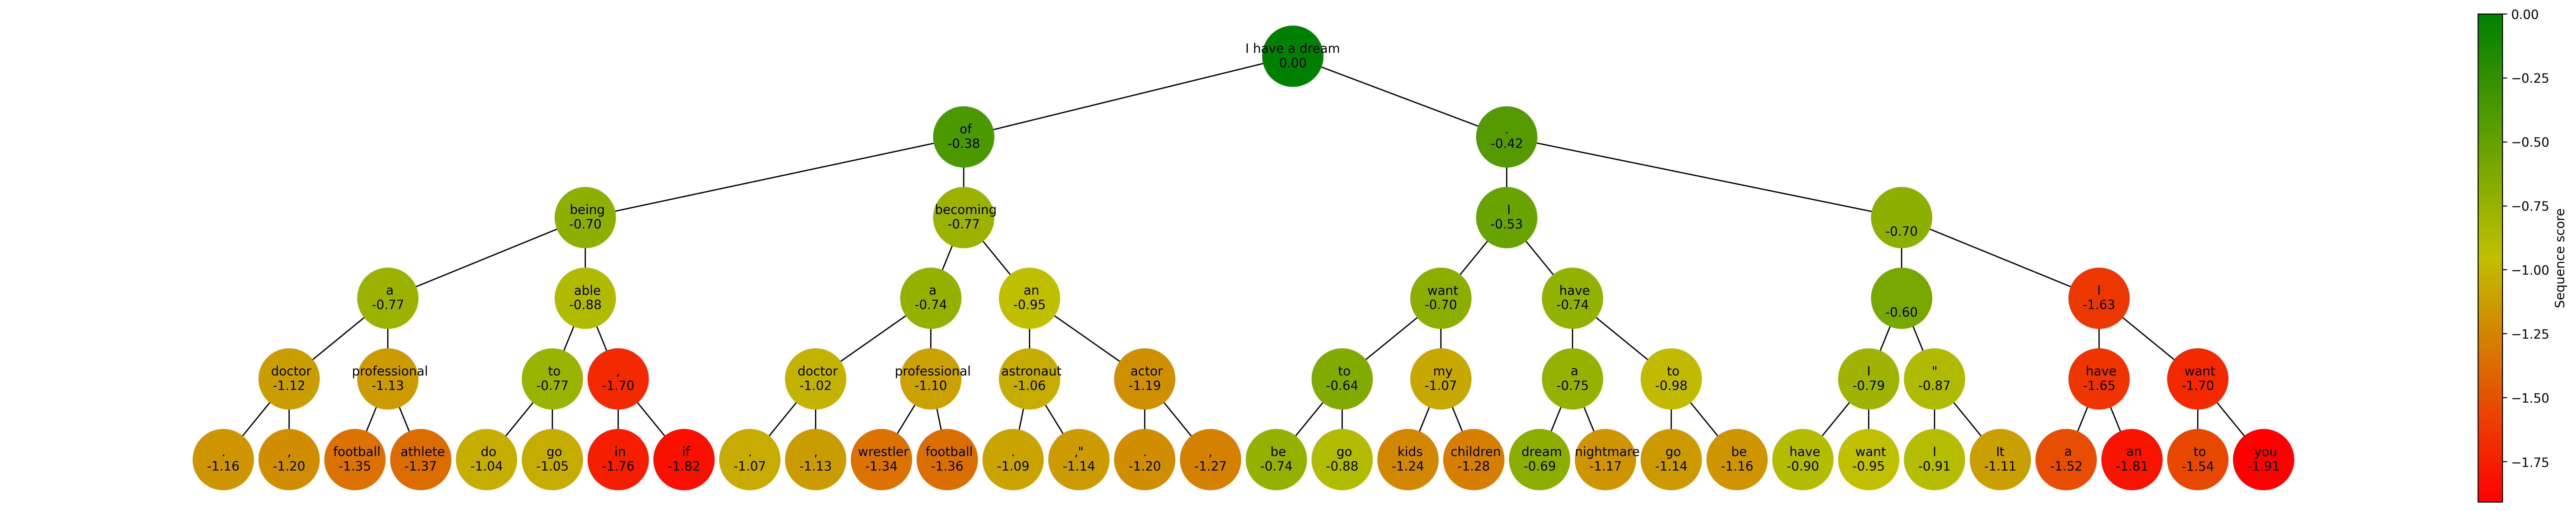

In [ ]:
plot_graph(graph, length, beams, 'sequence')

Действительно, токен "dream" имеет самый высокий балл последовательности со значением -0.69. Интересно, что мы можем увидеть балл жадной последовательности "I have a dream of being a doctor." в самой левом листе со значением -1.16.

Как и ожидалось, жадный поиск приводит к субоптимальным результатам. Но, честно говоря, наш новый результат тоже не особенно убедителен. Чтобы генерировать более разнообразные последовательности, мы реализуем два алгоритма выборки: top-k и nucleus-sampling.

## Top-k sampling

Top-k sampling - это техника, которая использует распределение вероятностей, сгенерированное языковой моделью, для случайного выбора токена из k наиболее вероятных вариантов.

Для примера предположим, что параметр k=3 и есть четыре токена: A, B, C и D с соответствующими вероятностями:
- P(A) = 30%
- P(B) = 15%
- P(C) = 5%
- P(D) = 1%

При сэмплировании Top-k токен D игнорируется, и алгоритм перевзвесит вероятности и будет выдавать A 60% времени, B 30% времени и C 10% времени. Этот подход гарантирует, что мы приоритетно отдаем предпочтение наиболее вероятным токенам, в то же время внося элемент случайности в процесс выбора.

Другой способ внесения случайности - это концепция температуры. Температура T - это параметр, который варьируется от 0 до 1 и влияет на вероятности, генерируемые функцией softmax, делая наиболее вероятные токены более влиятельными. На практике это просто заключается в делении входных логитов на значение, которое мы называем температурой:

$$
\text{softmax}(x_i) = \frac{e^{x_i / T}}{\sum_j e^{x_j / T}}
$$

где:
- $x_i$ логит конкретного токена.
- $T$ температура, влияющая на сшлаженность распределения.
- В знаменателе стоит сумма всех экспонент логитов скорректированных температурой.


Вот диаграмма, показывающая влияние температуры на вероятности, генерируемые для данного набора входных логитов [1.5, -1.8, 0.9, -3.2]. Графики представлены для трех различных значений температуры, чтобы пронаблюдать различия в значениях.

![](./data/images/sampling_3.png)

Температура 1.0 эквивалентна стандартной функции softmax без температуры. С другой стороны, низкие значения температуры (0.1) значительно изменяют распределение вероятностей. Это часто используется в генерации текста для контроля уровня "креативности" в генерируемом тексте. Регулируя температуру, мы можем влиять на степень, в которой модель производит более разнообразные или предсказуемые ответы.

Теперь давайте реализуем алгоритм top-k семплинга. Мы будем использовать его в функции beam_search(), предоставляя аргумент "top_k". Чтобы проиллюстрировать, как работает алгоритм, также построим графики распределения вероятностей для top_k=20.

--------------------------------------------------------------

In [ ]:
def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convert logits to probabilities and do not forget temperature adjuctment
    probabilities = None   # YOUR_CODE_HERE

    # Sample n tokens from the resulting distribution
    next_tokens = None  # YOUR_CODE_HERE

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

Данный код - это функция на языке Python с названием top_k_sampling, которая выполняет top-k сэмплирование на заданном распределении вероятностей, представленном в виде logits. Функция принимает четыре аргумента: logits, temperature, top_k и beams. Аргумент logits - это тензор, представляющий распределение вероятностей.

Аргумент temperature - это скалярное значение, которое контролирует случайность процесса сэмплирования. Аргумент top_k - это целое число, которое определяет количество токенов top-k, которые нужно рассматривать для сэмплирования. Аргумент beams - это целое число, которое определяет количество сэмплов для генерации.

Функция сначала фильтрует токены с вероятностью меньше порога top-k, затем преобразует оставшиеся logits в вероятности с помощью softmax и, наконец, сэмплирует beams токенов из полученного распределения. Если plot установлен в True, функция также строит график распределения вероятностей. Функция возвращает тензор формы (beams,), содержащий сэмплированные токены.

In [ ]:
# solved

def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Sample n tokens from the resulting distribution
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

In [ ]:
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    # Get top k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    # Get next tokens and their probabilities
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Create figure
    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)

![](./data/images/sampling.gif)

Эти графики хорошо иллюстрируют, как работает top-k sampling, с потенциально выбранными токенами слева от горизонтальной полосы. Хотя наиболее вероятные токены выбираются (отмечены красным) в большинстве случаев, она также позволяет выбирать менее вероятные токены. Это предлагает интересный компромисс, который может направить последовательность к менее предсказуемому, но более естественно звучащему предложению. Теперь давайте напечатаем текст, который был сгенерирован.

In [ ]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream, I am going to


Выборка top-k нашла новую последовательность: "I have a dream: I'm going to", что звучит значительно более естественно, чем "I have a dream. I have a dream". Прогресс ощутим!

Давайте посмотрим, чем это дерево решений отличается от предыдущего.

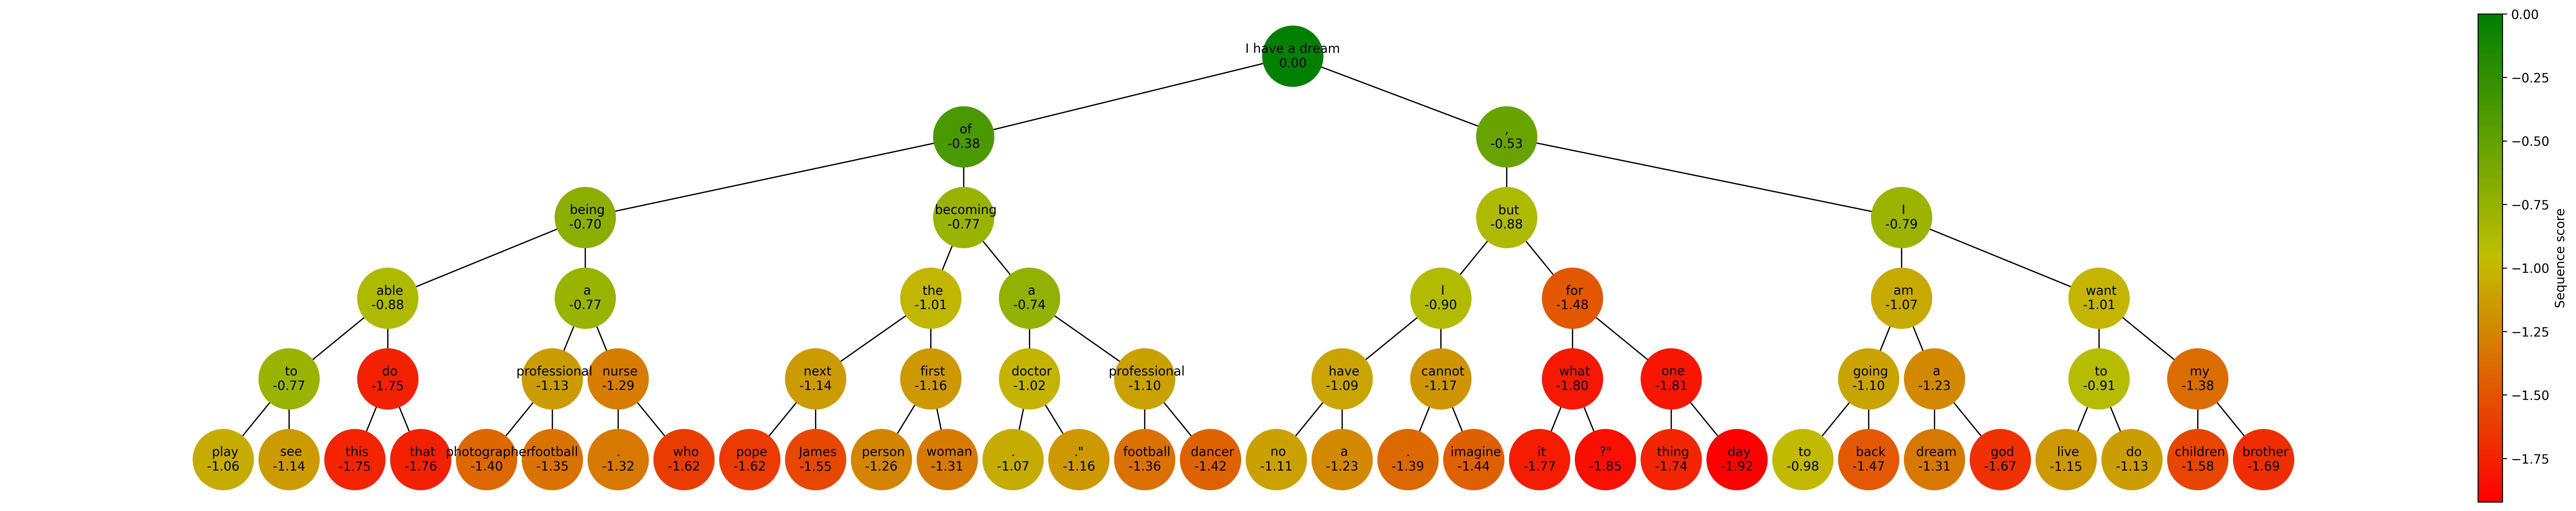

In [ ]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

Вы можете видеть, как узлы значительно отличаются от предыдущей итерации, делая более разнообразные выборы. Хотя оценка последовательности для новой сгенерированной последовательности может быть не самой высокой (-1.01 вместо -0.69 ранее), важно помнить, что более высокие оценки не всегда приводят к более реалистичным или значимым текстам.

Теперь, когда мы ввели выборку top-k, нам нужно представить другую самую популярную технику семплирования: nucleus sampling.

## Nucleus sampling

Идея Nucleus sampling берется из [этой](https://arxiv.org/abs/1904.09751) статьи. На практике это самый часто используемый метод семплирования который отлично подходит для внедрения в production.

In [ ]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    # YOUR_CODE_HERE

    # Create a mask for probabilities that are in the top-p
    mask = None # YOUR_CODE_HERE

    # If there's not n index where cumulative_probabilities < p, we use the top n tokens instead
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    # Sample n tokens from the resulting distribution
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

In [ ]:
# solved

def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    # Create a mask for probabilities that are in the top-p
    mask = cumulative_probabilities < p

    # If there's not n index where cumulative_probabilities < p, we use the top n tokens instead
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    # Sample n tokens from the resulting distribution
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

На этом графике вы можете видеть, что количество токенов, содержащихся в ядре до разделющей (входящих в top-p) вертикальной прямой, сильно колеблется. Сгенерированные распределения вероятностей значительно различаются, что приводит к выбору токенов, которые не всегда находятся среди наиболее вероятных. Это открывает новые возможности к созданию уникальных и разнообразных последовательностей. Теперь давайте посмотрим на текст, который сгенерировался.

In [ ]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. And it's my


Nucleus sampling генерирует последовательность: "I have a dream. And it's my", что демонстрирует заметное улучшение семантической связности по сравнению с жадной выборкой.

Чтобы сравнить пути принятия решений, давайте визуализируем новое дерево, сгенерированное выборкой ядра.

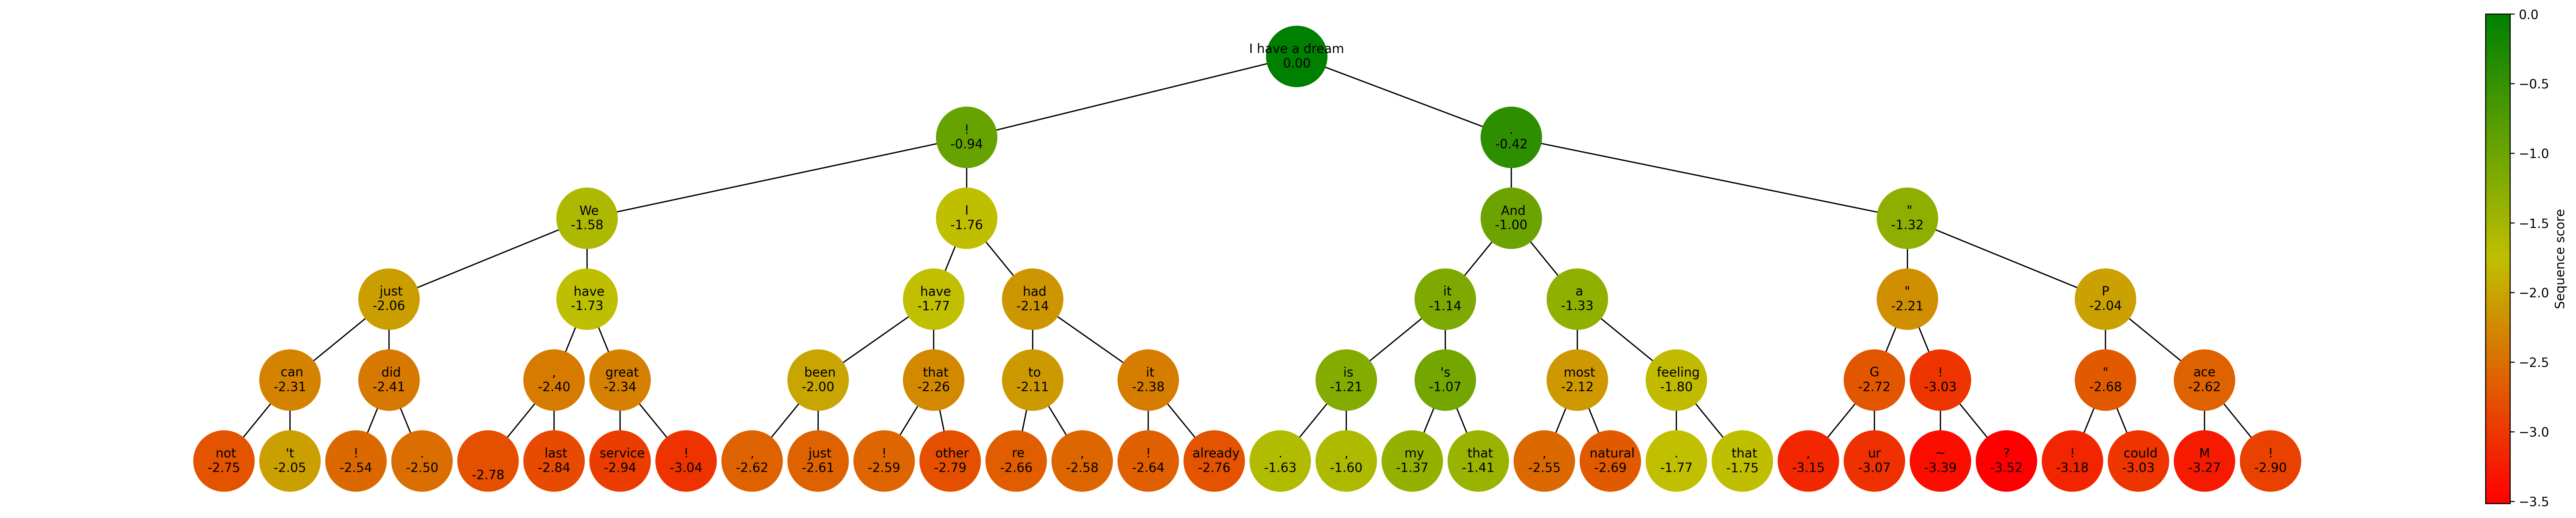

In [ ]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

Как и в случае с выборкой top-k, это дерево сильно отличается от дерева, сгенерированного с помощью жадного выбора, демонстрируя большее разнообразие. Как top-k sampling, так и nucleus sampling предлагают уникальные преимущества при генерации текста, повышая разнообразие и визуально улучшая результат. Ваш выбор между этими двумя методами (или даже жадным поиском) будет зависеть от конкретных требований и ограничений вашего проекта.

## Выводы